In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd
import torch
import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

from sklearn.model_selection import train_test_split

## Setup

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [5]:
set_seed(42)

In [6]:
DATASET_PATH = '../datasets'

!mkdir -p {DATASET_PATH}

In [7]:
MIN_PRODUCT_BY_CATEGORY = 5
MAX_PRODUCT_TITLE_SIZE  = 150

In [8]:
def plot_categories(groups):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=groups['category'], y='title', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()
    
def plot_title_size(df):
    plt.figure(figsize=(15,10))
    ax = sns.barplot(x='title_size', y='title', data=df)
    ax.set(ylabel=None)
    ax.set(yticklabels=[])
    plt.show()

## Preprocesamiento

In [9]:
raw_dataset = pd.read_csv(f'{DATASET_PATH}/ebay-dataset.csv')

Renombramos las columnas a title y category:

In [10]:
raw_dataset = raw_dataset[['name', 'breadcrumbs']]
raw_dataset = raw_dataset.rename(columns={'name':'title', 'breadcrumbs': 'category'})

In [11]:
raw_dataset.shape

(3003, 2)

Nos quedamos con las categorias que tienen como minimo MIN_PRODUCT_BY_CATEGORY:

In [12]:
groups = ut.group_by_count(raw_dataset, ['category'], 'title')
groups = groups[groups['title'] >= MIN_PRODUCT_BY_CATEGORY ]
groups.head()

,category,title
8,"eBay ~ Books, Comics & Magazines ~ Books",220
607,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,67
680,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,54
564,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,54
687,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,52


In [13]:
groups.shape

(122, 2)

In [14]:
filtered_dataset = raw_dataset[raw_dataset['category'].isin(groups['category'])]
filtered_dataset.head()

,title,category
1,MERCEDES VANEO 414 1.6 Pollen / Cabin Filter 0...,eBay ~ Vehicle Parts & Accessories ~ Car Parts...
2,Windscreen Kappa Transparent 58x45cm for April...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
4,Honda RS 250 R 1991-1994 DP Brakes Street Sint...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
5,JMT X-ring 530x2 Gold 104 Open Chain With Rive...,eBay ~ Vehicle Parts & Accessories ~ Motorcycl...
7,1x Summer Tyre Michelin Pilot Sport 4 255/40zr...,eBay ~ Vehicle Parts & Accessories ~ Car Wheel...


In [15]:
raw_dataset.shape, filtered_dataset.shape

((3003, 2), (1934, 2))

Seleccionamos los productos con descripciones menores a 100 caracteres:

<Figure size 1080x720 with 1 Axes>

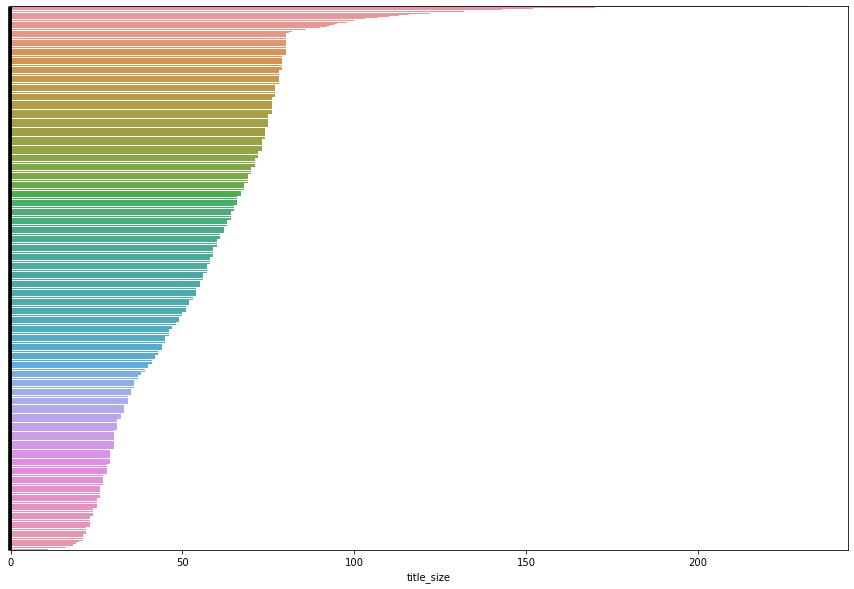

In [16]:
filtered_dataset['title_size'] = filtered_dataset['title'].apply(len)
filtered_dataset = filtered_dataset.sort_values(['title_size'], ascending=False)

plot_title_size(filtered_dataset)

<Figure size 1080x720 with 1 Axes>

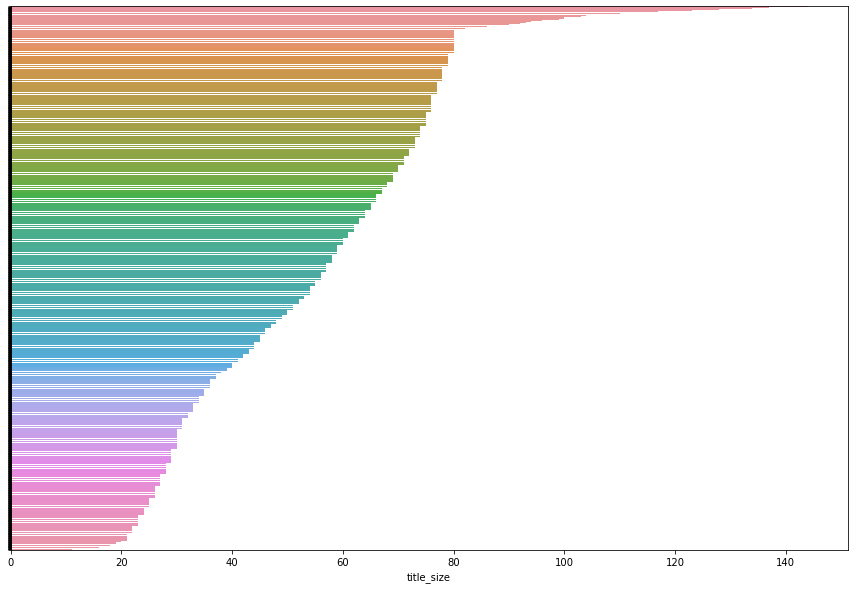

In [17]:
filtered_dataset = filtered_dataset[filtered_dataset['title_size'] < MAX_PRODUCT_TITLE_SIZE]

plot_title_size(filtered_dataset)

In [18]:
groups = ut.group_by_count(filtered_dataset, ['category'], 'title')
groups = groups[groups['title'] >= MIN_PRODUCT_BY_CATEGORY ]
groups.head()

,category,title
0,"eBay ~ Books, Comics & Magazines ~ Books",213
61,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,67
38,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,54
90,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,54
95,eBay ~ Vehicle Parts & Accessories ~ Car Parts...,52


In [19]:
groups.shape

(122, 2)

In [20]:
filtered_dataset = filtered_dataset[filtered_dataset['category'].isin(groups['category'])]

In [21]:
filtered_dataset = filtered_dataset.drop(columns=['title_size'])
filtered_dataset.head()

,title,category
1301,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books"
2430,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books"
2423,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books"
2293,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books"
593,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books"


<Figure size 720x360 with 1 Axes>

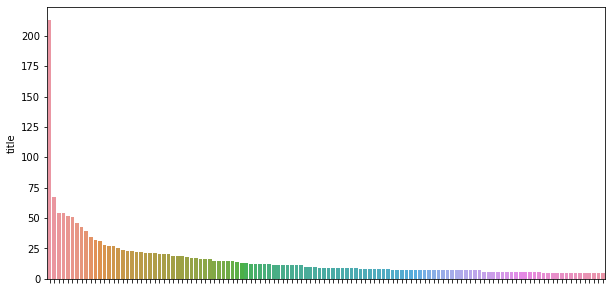

In [22]:
plot_categories(ut.group_by_count(filtered_dataset, ['category'], 'title'))

Agregamos un número de secuencia que representa a la categoria:

In [24]:
filtered_dataset = dt.Sequencer('category', 'category_seq').perform(filtered_dataset)
filtered_dataset.head()

,title,category,category_seq
0,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books",0
1,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books",0
2,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books",0
3,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books",0
4,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books",0


In [26]:
filtered_dataset['category_seq'].min(), filtered_dataset['category_seq'].max()

(0, 121)

Partimos el dataset en los conjuntos de entrenamiento, prueba y validación:

In [27]:
train_set, test_set, _, _= train_test_split(
    filtered_dataset,
    filtered_dataset['category'].values,
    test_size     = 0.1,
    stratify      = filtered_dataset['category'].values,
    shuffle       = True
)

In [28]:
test_set, val_set, _, _= train_test_split(
    test_set,
    test_set['category'].values,
    test_size     = 0.5,
    shuffle       = True
)

Chequeamos que en test y evaliacion existan las misma categorias que existe en train:

<Figure size 720x360 with 1 Axes>

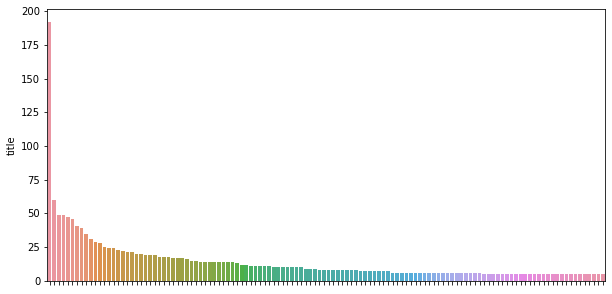

In [29]:
plot_categories(ut.group_by_count(train_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

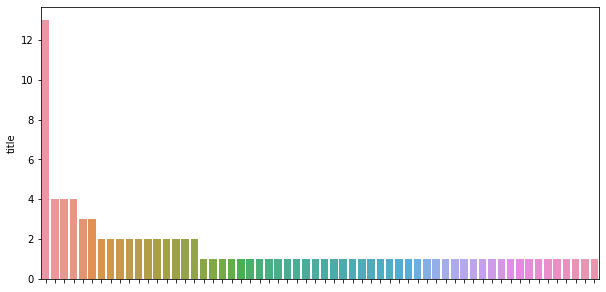

In [30]:
plot_categories(ut.group_by_count(test_set, ['category'], 'title'))

<Figure size 720x360 with 1 Axes>

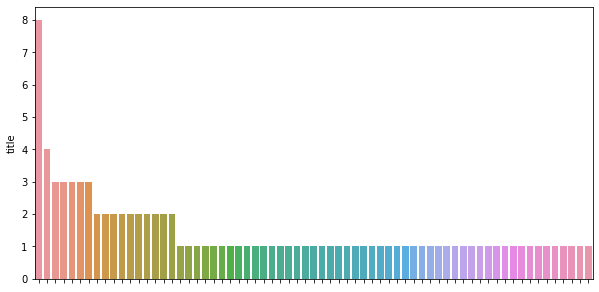

In [31]:
plot_categories(ut.group_by_count(val_set, ['category'], 'title'))

In [32]:
train_set.shape, val_set.shape, test_set.shape

((1731, 3), (97, 3), (96, 3))

In [33]:
val_set[val_set['category'].isin(train_set['category'].values)].shape

(97, 3)

In [34]:
test_set[test_set['category'].isin(train_set['category'].values)].shape

(96, 3)

Guardamos todos los conjuntos preprocesados:

In [35]:
train_set.to_csv(f'{DATASET_PATH}/ebay-train.csv', index=False)
val_set.to_csv(f'{DATASET_PATH}/ebay-val.csv', index=False)
test_set.to_csv(f'{DATASET_PATH}/ebay-test.csv', index=False)
filtered_dataset.to_csv(f'{DATASET_PATH}/ebay-all.csv', index=False)